This code creates a buffer(50 meters max) around the spill points and finds the nearest flowline intersection, asserting that the operator name is the same. It then changes the matches spills geometry location to its respective flowline intersection point. 

- you cannot export 2 geometry columns, so we only kept the flowline geometry, not the spills

## Setup

In [1]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiLineString, LineString, Point
from shapely.ops import nearest_points

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')
pd.options.display.max_columns = None

In [2]:
# Load Data
matched_flowlines_gdf = gpd.read_file('matched_flowlines.geojson')
spills_gdf = gpd.read_file('spills.geojson')

In [3]:
# Check if CRS is the same for both files
if matched_flowlines_gdf.crs != spills_gdf.crs:
    flowlines_gdf = matched_flowlines_gdf.to_crs(spills_gdf.crs)

In [4]:
print(spills_gdf.crs)
print(matched_flowlines_gdf.crs)

EPSG:26913
EPSG:26913


In [5]:
# Check size
print(matched_flowlines_gdf.shape)
print(spills_gdf.shape)

(14922, 27)
(849, 14)


In [6]:
print(spills_gdf.is_valid.all())
print(matched_flowlines_gdf.is_valid.all())

False
True


In [7]:
spills_gdf = spills_gdf[spills_gdf.is_valid]
matched_flowlines_gdf = matched_flowlines_gdf[matched_flowlines_gdf.is_valid]

In [8]:
print(spills_gdf.is_valid.all())
print(matched_flowlines_gdf.is_valid.all())

True
True


In [9]:
matched_flowlines_gdf.head(2)

,ACTIONDESCRIPTION,BEDDINGMATERIAL,COMPANY_NAME,CONSTRUCTDATE,Diam_in,ENDLAT,ENDLONG,ENTIRELINEREMOVED,FLOWLINEACTION,FLOWLINEID,Fluid,LOCATIONTYPE,LOCATION_ID,Length_ft,MAXOPPRESSURE,Material,OPERATOR_NUM,Operator,PIPEMATERIAL,RECEIVE_DATE,SHAPE_Length,STARTLAT,STARTLOCATIONID,STARTLONG,Status,TYPEOFFLUIDTRANS,geometry
0,The flowline serving the Emerson 3-29J (05-123...,Native Materials,CRESTONE PEAK RESOURCES OPERATING LLC ...,1983-11-09,2.0,40.109444,-104.909686,None,None,470446.0,Multiphase,Production Facilities,470443.0,1361.28,325.0,Carbon Steel,10633,CRESTONE PEAK RESOURCES OPERATING LLC,Carbon Steel,2023-10-24 08:33:49.223,414.751530,40.105743,NaN,-104.909860,Active,Multiphase,"MULTILINESTRING ((507682.447 4439497.657, 5076..."
1,The flowline (12311399_FL) servicing the Emers...,Native Materials,CRESTONE PEAK RESOURCES OPERATING LLC ...,1983-12-07,2.0,40.109441,-104.909670,1,Out of Service,470445.0,Multiphase,Production Facilities,470443.0,1025.98,250.0,Carbon Steel,10633,CRESTONE PEAK RESOURCES OPERATING LLC,Carbon Steel,2023-10-24 08:33:49.223,312.594254,40.112203,319521.0,-104.909862,Active,Multiphase,"MULTILINESTRING ((507681.553 4440214.644, 5076..."


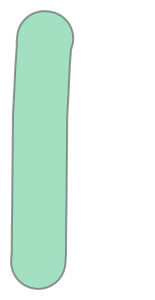

In [10]:
matched_flowlines_gdf["geometry"].head(1)[0]
matched_flowlines_gdf["geometry"].head(1).buffer(50)[0]

In [11]:
spills_gdf.head(2)

,trkg_num,Operator Name,facility_type,Spill_Desc,Spill Type,Root Cause,Preventative Measure,Root Cause Type,Detailed Root Cause Type,Long,Lat,facility_status,Metallic?,geometry
0,401530532,K P KAUFFMAN COMPANY INC,FLOWLINE,Historical contamination was discovered during...,1,Facility #7 consolidation line failed do to un...,The damaged section of flowline was repaired a...,Unknown,Unknown,-104.914183,40.019361,CL,Unknown,POINT (507323.245 4429909.631)
1,401524345,GREAT WESTERN OPERATING COMPANY LLC,TANK BATTERY,Soil impacts were discovered during removal of...,1,Unknown,None,Unknown,Unknown,-104.467746,39.602613,AC,Unknown,POINT (545695.434 4383787.964)


In [12]:
import geopandas as gpd

# Initialize an empty list to store matched data and a set for matched flowline indices
matched_spills = []
matched_flowline_indices = set()

max_buffer_distance = 25  # Maximum buffer distance in meters
buffer_increment = 0.5    # Buffer increment in meters

# Create spatial index for the flowlines geometries
flowlines_sindex = matched_flowlines_gdf.sindex

for index, spill in spills_gdf.iterrows():
    if spill.geometry is None:
        print(f"Missing geometry for spill at index {index}. Skipping...")
        continue

    buffer_distance = 0
    match_found = False

    while buffer_distance <= max_buffer_distance and not match_found:
        buffered_spill = spill.geometry.buffer(buffer_distance)
        possible_matches_index = list(flowlines_sindex.intersection(buffered_spill.bounds))
        possible_matches = matched_flowlines_gdf.iloc[possible_matches_index]

        for flowline_index, flowline in possible_matches.iterrows():
            if buffered_spill.intersects(flowline.geometry):
                if spill['Operator Name'].strip().lower() == flowline['Operator'].strip().lower():
                    print(f"Operator match found at buffer distance {buffer_distance} meters for spill at index {index}.")
                    match_found = True
                    matched_flowline_indices.add(flowline_index)  # Track matched flowline index
                    print(f"Adding match: Flowline index {flowline_index}")

                    updated_spill = spill.copy()
                    updated_spill.geometry = flowline.geometry
                    for col in flowline.index:
                        updated_spill[col] = flowline[col]

                    matched_spills.append(updated_spill)
                    break

        if not match_found:
            buffer_distance += buffer_increment

    if not match_found:
        print(f"No operator match found for spill at index {index} even after expanding buffer to {max_buffer_distance} meters.")

matched_spills_gdf = gpd.GeoDataFrame(matched_spills, columns=spills_gdf.columns.union(matched_flowlines_gdf.columns), crs=spills_gdf.crs)

No operator match found for spill at index 0 even after expanding buffer to 25 meters.
No operator match found for spill at index 1 even after expanding buffer to 25 meters.
No operator match found for spill at index 2 even after expanding buffer to 25 meters.
No operator match found for spill at index 3 even after expanding buffer to 25 meters.
No operator match found for spill at index 4 even after expanding buffer to 25 meters.
No operator match found for spill at index 5 even after expanding buffer to 25 meters.
No operator match found for spill at index 6 even after expanding buffer to 25 meters.
No operator match found for spill at index 7 even after expanding buffer to 25 meters.
No operator match found for spill at index 8 even after expanding buffer to 25 meters.
No operator match found for spill at index 9 even after expanding buffer to 25 meters.
No operator match found for spill at index 10 even after expanding buffer to 25 meters.
No operator match found for spill at index

In [13]:
# Create a GeoDataFrame of unmatched flowlines
unmatched_flowlines_gdf = matched_flowlines_gdf.drop(index=list(matched_flowline_indices))

print(f"Total flowlines: {len(matched_flowlines_gdf)}")
print(f"Matched flowlines: {len(matched_flowline_indices)}")
print(f"Matched spills: {len(matched_spills_gdf)}")
print(f"Unmatched flowlines: {len(unmatched_flowlines_gdf)}")

Total flowlines: 14922
Matched flowlines: 69
Matched spills: 84
Unmatched flowlines: 14853


In [14]:
matched_spills_gdf.to_file("flowlines_with_spills.geojson", driver='GeoJSON')

In [15]:
unmatched_flowlines_gdf.to_file("flowlines_without_spills.geojson", driver='GeoJSON')